<a href="https://colab.research.google.com/github/hnf71z/mytubes_ml/blob/main/4_33_23_1_09_Hanif_Abdusy_Syakur_TUBESAI_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####-- IDENTITAS --
#####NAMA       : HANIF ABDUSY SYAKUR
#####NIM        : 4.33.23.1.09
#####KELAS      : TI-2B



In [2]:
# Import dataset dari gdrive
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/project_ml/taco-dataset"

!cp -r "/content/drive/My Drive/project_ml/taco-dataset" "/content/taco-dataset"

Mounted at /content/drive


In [3]:
# Import Libraries
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

In [4]:
# Konversi dataset YOLO ke format klasifikasi untuk CNN
# Folder YOLO: taco-dataset/train/images, taco-dataset/train/labels, dst.
# Folder CNN: taco-dataset_cnn/train/<class_name>/*.jpg, dst.

def yolo_to_classification(yolo_dir, out_dir, split='train'):
    images_dir = os.path.join(yolo_dir, split, 'images')
    labels_dir = os.path.join(yolo_dir, split, 'labels')
    os.makedirs(out_dir, exist_ok=True)
    img_files = glob.glob(os.path.join(images_dir, '*.jpg'))
    for img_path in tqdm(img_files, desc=f'Processing {split} images'):
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_dir, base + '.txt')
        if not os.path.exists(label_path):
            continue
        with open(label_path) as f:
            lines = f.readlines()
        # Hanya gunakan gambar dengan satu objek (satu kelas)
        if len(lines) != 1:
            continue
        class_id = lines[0].split()[0]
        class_dir = os.path.join(out_dir, split, class_id)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(class_dir, os.path.basename(img_path)))

# Jalankan konversi untuk train, valid, test
yolo_dir = '/content/taco-dataset'
cnn_dir = '/content/taco-dataset_cnn'
for split in ['train', 'valid', 'test']:
    yolo_to_classification(yolo_dir, cnn_dir, split=split)

print('Konversi selesai. Struktur dataset CNN siap digunakan.')

Processing test images: 100%|██████████| 100/100 [00:00<00:00, 8553.87it/s]

Konversi selesai. Struktur dataset CNN siap digunakan.


In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 838.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [1]:
# Tahap 2: Training Model YOLOv8 dengan K-Fold dan Early Stopping

try:
    from ultralytics import YOLO
    import torch
    from sklearn.model_selection import KFold
    import numpy as np
    import os
    import shutil
except ModuleNotFoundError:
    print("Error: Library 'ultralytics' atau 'torch' atau 'sklearn' atau 'numpy' tidak ditemukan.")
    print("Mohon jalankan sel '!pip install ultralytics' terlebih dahulu.")
    print("Jika error masih muncul setelah instalasi, coba 'Restart runtime' dan jalankan semua sel lagi.")
    raise

# Konfigurasi GPU (MPS untuk Mac)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training akan menggunakan: {device.upper()}")

# Path ke file konfigurasi dataset
data_yaml_path = '/content/taco-dataset/data.yaml'

# Parameter training
num_folds = 2 # Jumlah fold untuk K-Fold Cross-Validation
epochs_per_fold = 100 # Jumlah maksimum epoch per fold (diubah menjadi 100)
imgsz_yolo = 320 # Ukuran gambar (diperkecil menjadi 320)
batch_size_yolo = 32 # Ukuran batch (bisa disesuaikan)
patience_yolo = 20 # Jumlah epoch tanpa peningkatan metrik validasi sebelum early stopping

# Untuk K-Fold dengan Ultralytics, kita perlu membagi dataset secara manual
# atau menggunakan fitur K-Fold jika tersedia di versi terbaru (cek dokumentasi Ultralytics)
# Karena Ultralytics v8.x belum memiliki fitur K-Fold built-in yang mudah diakses untuk training,
# cara paling umum adalah menjalankan training beberapa kali dengan subset data yang berbeda.
# Namun, ini akan membutuhkan modifikasi yang signifikan pada struktur dataset atau menggunakan API Ultralytics yang lebih dalam.

# Alternatif yang lebih sederhana untuk simulasi K-Fold:
# Kita bisa menjalankan training dengan set validasi yang sama tetapi mencatat hasil dari setiap 'fold'
# atau menjalankan training 5 kali secara terpisah dengan konfigurasi validasi yang berbeda.
# Metode yang paling umum dan didukung langsung oleh Ultralytics adalah menjalankan training satu kali
# dengan dataset dan validasi yang sudah dibagi, dan menggunakan fitur Early Stopping bawaan.

# Mari kita fokus pada penggunaan Early Stopping bawaan Ultralytics
# Early Stopping di Ultralytics diaktifkan dengan parameter 'patience'.

print(f"Memulai training YOLOv8 dengan Early Stopping (patience={patience_yolo})...")

# Memuat Model & Training
model_yolo = YOLO('yolov8n.pt')

# Mulai training
results = model_yolo.train(
    data=data_yaml_path,
    epochs=epochs_per_fold, # Menggunakan jumlah epoch yang diperbesar
    imgsz=imgsz_yolo,      # Menggunakan ukuran gambar yang diperkecil
    name='yolov8n_taco_detection_earlystop', # Nama hasil training yang diperbarui
    batch=batch_size_yolo,
    patience=patience_yolo # Mengaktifkan Early Stopping
)

print("\nTraining YOLOv8 selesai.")
print(f"Hasil training tersimpan di folder 'runs/detect/yolov8n_taco_detection_earlystop'.")

# Catatan: Implementasi K-Fold yang sebenarnya dengan Ultralytics memerlukan
# pembagian dataset secara manual untuk setiap fold dan menjalankan training
# secara terpisah, yang akan jauh lebih kompleks.
# Kode di atas hanya mengaktifkan Early Stopping bawaan Ultralytics
# dengan parameter epoch dan imgsz yang diminta.

Training akan menggunakan: CUDA
Memulai training YOLOv8 dengan Early Stopping (patience=20)...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/taco-dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_taco_detection_earlystop2, nbs=64, nms=False, 

train: Scanning /content/taco-dataset/train/labels... 4200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4200/4200 [00:07<00:00, 529.73it/s]


train: New cache created: /content/taco-dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 19.1±6.5 MB/s, size: 35.4 KB)


val: Scanning /content/taco-dataset/valid/labels... 1704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1704/1704 [00:03<00:00, 518.71it/s]


val: New cache created: /content/taco-dataset/valid/labels.cache
Plotting labels to runs/detect/yolov8n_taco_detection_earlystop2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_taco_detection_earlystop2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.22G      1.443      3.996      1.194         37        320: 100%|██████████| 132/132 [00:34<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


                   all       1704       4830      0.553     0.0905     0.0439     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.99G      1.442       2.96      1.175         58        320: 100%|██████████| 132/132 [00:30<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


                   all       1704       4830      0.249      0.183     0.0613     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.01G      1.391      2.725      1.164         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


                   all       1704       4830      0.272      0.148     0.0675     0.0442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.02G      1.396      2.623      1.172         20        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


                   all       1704       4830      0.287      0.166     0.0966      0.062

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.04G      1.359      2.482      1.162         45        320: 100%|██████████| 132/132 [00:36<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:14<00:00,  1.91it/s]


                   all       1704       4830      0.271      0.185      0.108     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.05G      1.319      2.343      1.131         50        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


                   all       1704       4830      0.266       0.16      0.109     0.0715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.07G      1.335      2.289      1.136         34        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


                   all       1704       4830      0.301      0.206      0.128     0.0866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.09G       1.32      2.226      1.125         22        320: 100%|██████████| 132/132 [00:31<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


                   all       1704       4830       0.26      0.182      0.123     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.11G      1.277      2.103      1.119         34        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]

                   all       1704       4830      0.291      0.193      0.134     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.12G      1.287      2.085      1.116         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


                   all       1704       4830      0.266      0.191      0.133     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.14G      1.267       2.02      1.102         31        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.21it/s]

                   all       1704       4830      0.305      0.209       0.15      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.16G      1.276      1.945      1.101         17        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


                   all       1704       4830      0.325       0.19      0.145      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.17G      1.249      1.899      1.104         36        320: 100%|██████████| 132/132 [00:29<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]

                   all       1704       4830      0.327      0.217      0.155      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.19G      1.246      1.855       1.09         48        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


                   all       1704       4830      0.383      0.183      0.168      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.21G      1.242      1.829      1.086         23        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.79it/s]

                   all       1704       4830      0.344      0.205      0.163      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.22G       1.22       1.77      1.079         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]

                   all       1704       4830       0.35      0.222      0.179      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.25G      1.223      1.713      1.084         45        320: 100%|██████████| 132/132 [00:29<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]

                   all       1704       4830        0.4      0.194      0.172      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.26G      1.203      1.674      1.074         33        320: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]


                   all       1704       4830       0.42      0.184      0.165      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.28G      1.209      1.647      1.075         42        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]

                   all       1704       4830      0.378      0.211      0.176      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.3G      1.188      1.596      1.065         33        320: 100%|██████████| 132/132 [00:29<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]

                   all       1704       4830      0.379      0.221      0.197      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.31G      1.188      1.561      1.068         51        320: 100%|██████████| 132/132 [00:29<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.35it/s]

                   all       1704       4830      0.409      0.212      0.194      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.33G      1.171      1.526      1.063         40        320: 100%|██████████| 132/132 [00:29<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]

                   all       1704       4830      0.455      0.218      0.201      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.34G      1.188      1.516      1.065         32        320: 100%|██████████| 132/132 [00:29<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]

                   all       1704       4830      0.372      0.223      0.193      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.36G      1.162      1.471      1.056         21        320: 100%|██████████| 132/132 [00:29<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


                   all       1704       4830      0.431      0.202      0.195      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.38G      1.163      1.456      1.048         43        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.32it/s]

                   all       1704       4830       0.45      0.212      0.212      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.4G      1.153      1.418      1.044         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

                   all       1704       4830      0.407      0.225      0.223      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G      1.147      1.386       1.05         24        320: 100%|██████████| 132/132 [00:29<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.445      0.237      0.227      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.43G       1.15      1.384      1.044         49        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


                   all       1704       4830      0.423      0.235      0.217       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.45G      1.135      1.336      1.036         14        320: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.19it/s]

                   all       1704       4830      0.407      0.234      0.219       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.46G      1.141       1.34       1.05         22        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.394      0.233      0.229      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.48G      1.121      1.294      1.038         31        320: 100%|██████████| 132/132 [00:29<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]

                   all       1704       4830      0.394       0.23       0.22       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.5G       1.13       1.29      1.037         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


                   all       1704       4830      0.412      0.236      0.238      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.52G      1.119       1.25      1.034         25        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]

                   all       1704       4830      0.406      0.249      0.225      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.53G      1.102      1.221      1.029         54        320: 100%|██████████| 132/132 [00:29<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.424      0.239      0.235      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.55G      1.113      1.232       1.03         37        320: 100%|██████████| 132/132 [00:29<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830      0.518       0.21      0.235      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.57G      1.102        1.2      1.027         33        320: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]

                   all       1704       4830      0.403       0.25      0.237      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.58G      1.103      1.185      1.028         28        320: 100%|██████████| 132/132 [00:29<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]

                   all       1704       4830      0.526      0.244      0.254      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.6G      1.106      1.178      1.025         44        320: 100%|██████████| 132/132 [00:29<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.483      0.236      0.245       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.62G      1.086      1.168      1.021         23        320: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830      0.392      0.256       0.24      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.63G      1.075      1.136      1.018         26        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]

                   all       1704       4830      0.529      0.227      0.248      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.65G      1.073      1.124      1.014         45        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


                   all       1704       4830      0.432      0.264      0.261      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.67G      1.067      1.115      1.012         23        320: 100%|██████████| 132/132 [00:30<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]

                   all       1704       4830      0.502      0.244      0.256      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.69G      1.089      1.104      1.017         19        320: 100%|██████████| 132/132 [00:29<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830      0.464      0.259      0.265      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.7G      1.064      1.082      1.008         55        320: 100%|██████████| 132/132 [00:29<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830       0.52      0.259      0.268      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.72G      1.065      1.081      1.007         44        320: 100%|██████████| 132/132 [00:29<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]

                   all       1704       4830      0.426      0.279      0.264      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.74G      1.042      1.049          1         23        320: 100%|██████████| 132/132 [00:30<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]

                   all       1704       4830      0.466       0.26      0.265      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.75G      1.058      1.059      1.007         27        320: 100%|██████████| 132/132 [00:29<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.505      0.265      0.278      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.77G      1.048      1.037          1         24        320: 100%|██████████| 132/132 [00:29<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]

                   all       1704       4830      0.583      0.244      0.273      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.79G       1.05      1.032     0.9979         34        320: 100%|██████████| 132/132 [00:29<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.37it/s]

                   all       1704       4830      0.473       0.26      0.268        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.8G      1.043      1.011     0.9995         26        320: 100%|██████████| 132/132 [00:30<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.02it/s]

                   all       1704       4830      0.527      0.257      0.281      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.82G       1.04      0.998     0.9939         21        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]

                   all       1704       4830      0.522      0.258      0.276      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.84G      1.045      1.012     0.9975         21        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]

                   all       1704       4830      0.487      0.258      0.275      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.86G       1.02     0.9856     0.9925         23        320: 100%|██████████| 132/132 [00:29<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.34it/s]

                   all       1704       4830      0.512      0.261      0.276      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.88G      1.032     0.9836     0.9961         42        320: 100%|██████████| 132/132 [00:30<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]

                   all       1704       4830      0.627      0.248      0.283      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.89G      1.014      0.967     0.9908         24        320: 100%|██████████| 132/132 [00:29<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830       0.64      0.243      0.281       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.91G      1.032     0.9706     0.9944         41        320: 100%|██████████| 132/132 [00:30<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

                   all       1704       4830       0.53      0.261      0.278      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.92G      1.004     0.9538      0.984         44        320: 100%|██████████| 132/132 [00:30<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


                   all       1704       4830       0.54      0.267       0.28      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.94G      1.005     0.9465     0.9898         26        320: 100%|██████████| 132/132 [00:30<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.34it/s]

                   all       1704       4830      0.496      0.267      0.277      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.96G      1.019     0.9374     0.9904         35        320: 100%|██████████| 132/132 [00:30<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.91it/s]

                   all       1704       4830       0.51      0.274      0.285      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.98G      1.008     0.9231     0.9841         44        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]

                   all       1704       4830      0.588      0.265      0.298      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         3G      1.011     0.9329      0.988         32        320: 100%|██████████| 132/132 [00:30<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.81it/s]

                   all       1704       4830      0.553      0.266      0.287      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.01G     0.9961     0.9224     0.9842         39        320: 100%|██████████| 132/132 [00:30<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]

                   all       1704       4830      0.535      0.276      0.295      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.03G     0.9849     0.8963     0.9778         34        320: 100%|██████████| 132/132 [00:31<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.36it/s]

                   all       1704       4830      0.605      0.256      0.292      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.04G      0.987     0.8967     0.9761         25        320: 100%|██████████| 132/132 [00:30<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]

                   all       1704       4830      0.596      0.276      0.297      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.06G     0.9824        0.9     0.9763         57        320: 100%|██████████| 132/132 [00:30<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

                   all       1704       4830      0.567      0.272      0.296      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.08G     0.9697     0.8731     0.9721         29        320: 100%|██████████| 132/132 [00:30<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.597      0.276      0.301      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.1G     0.9768     0.8815     0.9717         32        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.32it/s]

                   all       1704       4830      0.583       0.27      0.296      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.11G      0.971     0.8673     0.9737         27        320: 100%|██████████| 132/132 [00:30<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.12it/s]

                   all       1704       4830      0.552      0.281      0.299      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.13G     0.9842     0.8754     0.9795         33        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

                   all       1704       4830      0.595      0.263      0.297      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.15G     0.9737     0.8552     0.9751         28        320: 100%|██████████| 132/132 [00:29<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.80it/s]

                   all       1704       4830      0.588      0.279        0.3      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.16G      0.966     0.8536     0.9702         65        320: 100%|██████████| 132/132 [00:29<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]

                   all       1704       4830      0.572      0.279      0.303      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.18G      0.965     0.8507     0.9689         58        320: 100%|██████████| 132/132 [00:30<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.38it/s]

                   all       1704       4830      0.576      0.277      0.304      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.2G     0.9624     0.8388     0.9672         40        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.89it/s]

                   all       1704       4830       0.59      0.282      0.302      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.21G     0.9587     0.8392     0.9673         29        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830      0.576      0.276      0.297      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.23G     0.9721     0.8435     0.9637         43        320: 100%|██████████| 132/132 [00:29<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


                   all       1704       4830      0.601      0.269      0.295      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.25G     0.9548     0.8175     0.9641         48        320: 100%|██████████| 132/132 [00:30<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]

                   all       1704       4830      0.612      0.273      0.304       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.26G      0.961     0.8253     0.9657         21        320: 100%|██████████| 132/132 [00:30<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]

                   all       1704       4830      0.631      0.277      0.306      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.29G     0.9388     0.8061     0.9608         26        320: 100%|██████████| 132/132 [00:30<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.585      0.283      0.308      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.3G     0.9398     0.8026     0.9609         17        320: 100%|██████████| 132/132 [00:29<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.616      0.274      0.305      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.31G     0.9364     0.8103     0.9603         56        320: 100%|██████████| 132/132 [00:30<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.36it/s]

                   all       1704       4830      0.543      0.292      0.309      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.33G     0.9455     0.7986     0.9619         28        320: 100%|██████████| 132/132 [00:30<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.00it/s]

                   all       1704       4830      0.582      0.279      0.308      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.35G     0.9362     0.7904       0.96         22        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.624      0.274      0.309      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.37G     0.9343     0.7907     0.9619         21        320: 100%|██████████| 132/132 [00:30<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.579      0.285      0.313      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.38G     0.9226     0.7693     0.9557         25        320: 100%|██████████| 132/132 [00:30<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]

                   all       1704       4830      0.652      0.275      0.312      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       3.4G     0.9223     0.7761     0.9519         41        320: 100%|██████████| 132/132 [00:31<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.35it/s]

                   all       1704       4830      0.617      0.281      0.314      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.42G     0.9196     0.7725     0.9468         21        320: 100%|██████████| 132/132 [00:30<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]

                   all       1704       4830       0.59      0.286      0.315      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.44G     0.9354     0.7773     0.9548         33        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.82it/s]

                   all       1704       4830      0.554      0.295      0.311      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.45G     0.9241     0.7769     0.9539         30        320: 100%|██████████| 132/132 [00:30<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]

                   all       1704       4830       0.57      0.297      0.315      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.47G     0.9103     0.7528      0.948         34        320: 100%|██████████| 132/132 [00:30<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.39it/s]

                   all       1704       4830      0.633      0.283      0.317      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.49G     0.9158     0.7667     0.9484         32        320: 100%|██████████| 132/132 [00:31<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]

                   all       1704       4830      0.598      0.284       0.31      0.234


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       3.5G     0.8415     0.6816     0.8946         17        320: 100%|██████████| 132/132 [00:30<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]

                   all       1704       4830      0.599       0.28      0.309      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.52G      0.826     0.6377      0.889         11        320: 100%|██████████| 132/132 [00:29<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.88it/s]

                   all       1704       4830      0.598      0.286       0.31      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.54G     0.8257     0.6285     0.8877         38        320: 100%|██████████| 132/132 [00:29<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.35it/s]

                   all       1704       4830      0.627      0.284      0.315      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.55G     0.8196     0.6241     0.8888         13        320: 100%|██████████| 132/132 [00:29<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]

                   all       1704       4830      0.616      0.284      0.316      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.57G     0.8123     0.6151     0.8832         13        320: 100%|██████████| 132/132 [00:29<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.85it/s]

                   all       1704       4830      0.626      0.284      0.315      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.59G     0.8126     0.6069     0.8878         31        320: 100%|██████████| 132/132 [00:29<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]

                   all       1704       4830      0.619      0.288      0.317      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.61G     0.8083     0.5976     0.8853         12        320: 100%|██████████| 132/132 [00:32<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.33it/s]

                   all       1704       4830      0.695      0.275      0.318      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.62G     0.8125     0.6029     0.8862         18        320: 100%|██████████| 132/132 [00:29<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.84it/s]

                   all       1704       4830        0.7      0.275      0.318      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.64G     0.8032     0.6034     0.8847         21        320: 100%|██████████| 132/132 [00:29<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]

                   all       1704       4830      0.687      0.277      0.318      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.66G     0.8104     0.5989     0.8848         31        320: 100%|██████████| 132/132 [00:28<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]

                   all       1704       4830      0.685      0.279       0.32      0.242



100 epochs completed in 1.098 hours.
Optimizer stripped from runs/detect/yolov8n_taco_detection_earlystop2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_taco_detection_earlystop2/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_taco_detection_earlystop2/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,158 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


                   all       1704       4830      0.682       0.28      0.319      0.242
        Aluminium foil         48         62      0.877      0.403      0.439      0.351
            Bottle cap        347        459      0.665      0.538      0.536      0.406
                Bottle        275        320      0.799      0.212      0.334      0.221
          Broken glass         13        123      0.777     0.0325     0.0324     0.0191
                   Can        187        267      0.614      0.517       0.56      0.437
                Carton        207        263      0.623      0.464      0.465      0.388
             Cigarette        223        565       0.68     0.0354       0.05     0.0301
                   Cup        162        186      0.592      0.516      0.552      0.422
                   Lid         82         93      0.706       0.31      0.413      0.326
          Other litter        148        178      0.745      0.219       0.27      0.204
         Other plasti

Melakukan deteksi pada gambar: /content/taco-dataset/valid/images/000088_jpg.rf.bc9b5f0df4d591e4d50ed0d9a3e70b06.jpg

image 1/1 /content/taco-dataset/valid/images/000088_jpg.rf.bc9b5f0df4d591e4d50ed0d9a3e70b06.jpg: 320x320 1 Plastic bag - wrapper, 9.3ms
Speed: 1.6ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)


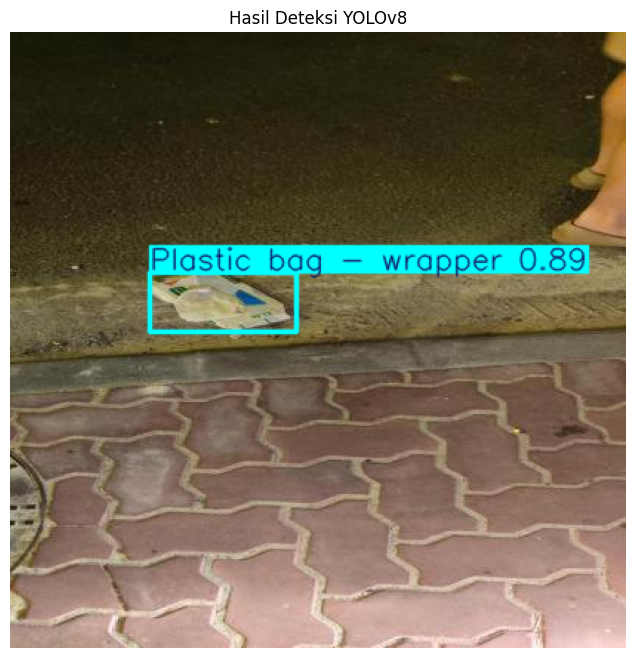

In [6]:
# Tahap 3: Inferensi (Uji Coba Deteksi) dengan Model YOLO

try:
    import cv2
    import matplotlib.pyplot as plt
    import os # Import os
    from ultralytics import YOLO # Import YOLO here as well
    import random # Import random module
except ModuleNotFoundError:
    print("Error: Library 'ultralytics', 'cv2', 'matplotlib', atau 'os' tidak ditemukan.")
    print("Mohon jalankan sel '!pip install ultralytics' dan pastikan library lainnya terinstal.")
    print("Jika error masih muncul setelah instalasi, coba 'Restart runtime' dan jalankan semua sel lagi.")
    # Exit or handle the error appropriately, for now, just print message
    raise # Re-raise the exception to stop execution


# Memuat Model Terbaik Hasil Training
# Path ke model terbaik akan berada di dalam folder hasil training
path_to_best_model = 'runs/detect/yolov8n_taco_detection/weights/best.pt' # Updated path

# Check if the model file exists before loading
if not os.path.exists(path_to_best_model):
    print(f"Error: Model terbaik tidak ditemukan di {path_to_best_model}.")
    print("Mohon pastikan training YOLOv8 (Tahap 2) telah selesai dengan sukses.")
else:
    model_yolo_best = YOLO(path_to_best_model)

    # Ambil satu gambar acak dari folder validasi untuk diuji
    valid_img_dir = '/content/taco-dataset/valid/images' # Updated path

    # Check if the directory exists and is not empty
    if not os.path.isdir(valid_img_dir) or not os.listdir(valid_img_dir):
        print(f"Error: Direktori gambar validasi tidak ditemukan atau kosong: {valid_img_dir}")
    else:
        path_gambar_uji = os.path.join(valid_img_dir, random.choice(os.listdir(valid_img_dir)))

        print(f"Melakukan deteksi pada gambar: {path_gambar_uji}")

        # Lakukan deteksi
        results_inference = model_yolo_best.predict(path_gambar_uji)

        # Tampilkan Hasil Deteksi
        # Hasil deteksi (results_inference) adalah list, kita ambil elemen pertama
        res_plotted = results_inference[0].plot() # plot() menghasilkan gambar dengan bounding box

        # Tampilkan gambar menggunakan matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
        plt.title("Hasil Deteksi YOLOv8")
        plt.axis('off')
        plt.show()

Mencari grafik hasil training YOLOv8...
Menampilkan grafik hasil training dari: runs/detect/yolov8n_taco_detection/results.png


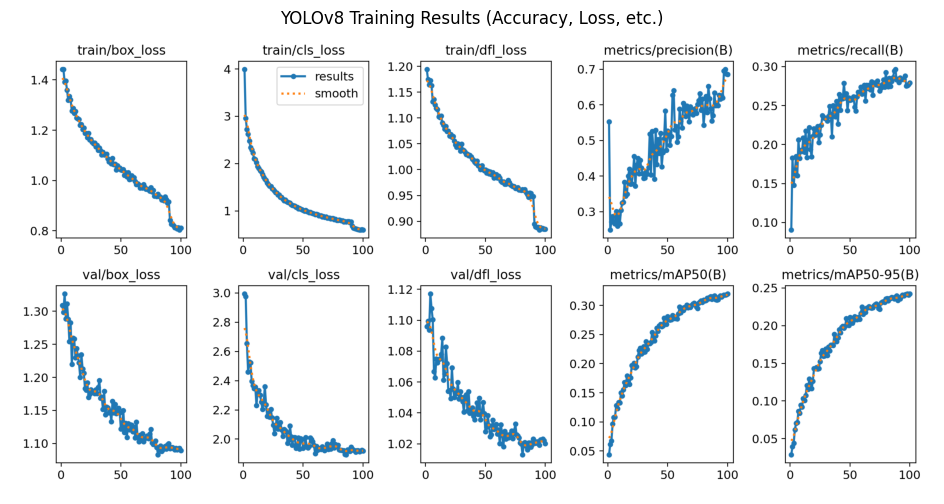

Menampilkan Confusion Matrix dari: runs/detect/yolov8n_taco_detection/confusion_matrix.png


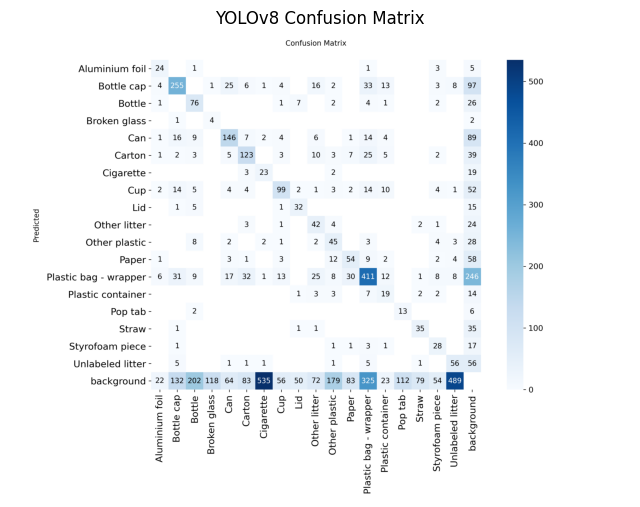

Menampilkan Label Plot dari: runs/detect/yolov8n_taco_detection/labels.jpg


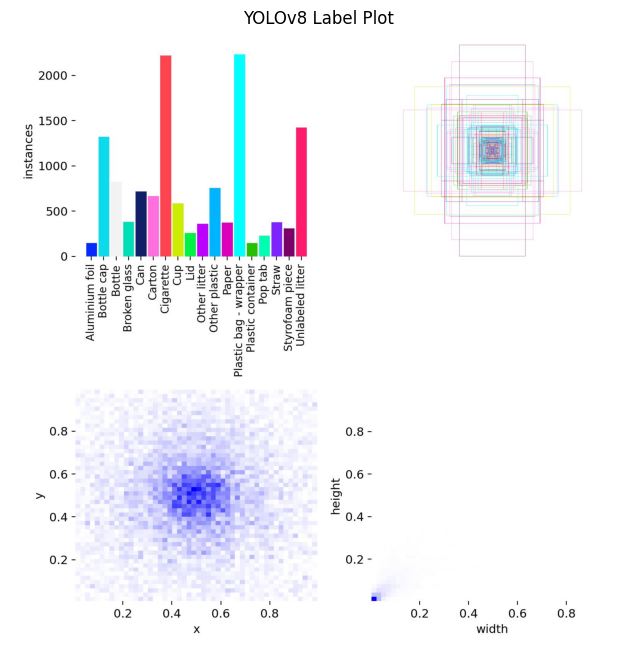

Menampilkan Label Correlogram dari: runs/detect/yolov8n_taco_detection/labels_correlogram.jpg


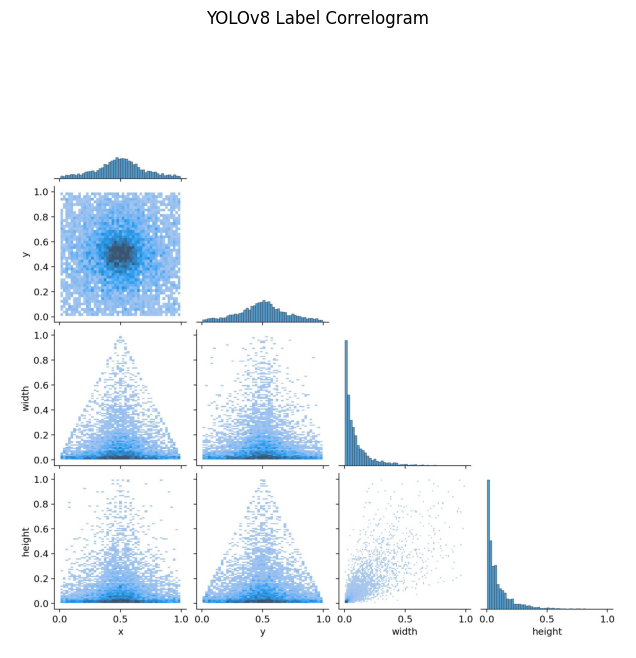

In [7]:
import matplotlib.pyplot as plt
import cv2
import os

# Path ke folder hasil training YOLOv8
# Pastikan nama folder sesuai dengan 'name' yang Anda berikan saat training
yolo_results_dir = 'runs/detect/yolov8n_taco_detection' # Updated path

# Path ke file grafik yang dihasilkan oleh Ultralytics
accuracy_plot_path = os.path.join(yolo_results_dir, 'results.png') # Ultralytics menyimpan banyak metrik di sini
confusion_matrix_path = os.path.join(yolo_results_dir, 'confusion_matrix.png')
labels_path = os.path.join(yolo_results_dir, 'labels.jpg')
labels_correlogram_path = os.path.join(yolo_results_dir, 'labels_correlogram.jpg')

print("Mencari grafik hasil training YOLOv8...")

# Tampilkan grafik hasil training (biasanya berisi akurasi, loss, dll.)
if os.path.exists(accuracy_plot_path):
    print(f"Menampilkan grafik hasil training dari: {accuracy_plot_path}")
    img_results = cv2.imread(accuracy_plot_path)
    if img_results is not None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img_results, cv2.COLOR_BGR2RGB))
        plt.title("YOLOv8 Training Results (Accuracy, Loss, etc.)")
        plt.axis('off')
        plt.show()
    else:
        print("Gagal membaca file gambar hasil training.")
else:
    print(f"Grafik hasil training tidak ditemukan di: {accuracy_plot_path}. Pastikan training YOLOv8 sudah selesai dan folder output sudah benar.")

# Anda juga bisa menampilkan grafik lainnya jika ada
if os.path.exists(confusion_matrix_path):
    print(f"Menampilkan Confusion Matrix dari: {confusion_matrix_path}")
    img_cm = cv2.imread(confusion_matrix_path)
    if img_cm is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_cm, cv2.COLOR_BGR2RGB))
        plt.title("YOLOv8 Confusion Matrix")
        plt.axis('off')
        plt.show()
    else:
         print("Gagal membaca file gambar Confusion Matrix.")


if os.path.exists(labels_path):
    print(f"Menampilkan Label Plot dari: {labels_path}")
    img_labels = cv2.imread(labels_path)
    if img_labels is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_labels, cv2.COLOR_BGR2RGB))
        plt.title("YOLOv8 Label Plot")
        plt.axis('off')
        plt.show()
    else:
         print("Gagal membaca file gambar Label Plot.")

if os.path.exists(labels_correlogram_path):
    print(f"Menampilkan Label Correlogram dari: {labels_correlogram_path}")
    img_lc = cv2.imread(labels_correlogram_path)
    if img_lc is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img_lc, cv2.COLOR_BGR2RGB))
        plt.title("YOLOv8 Label Correlogram")
        plt.axis('off')
        plt.show()
    else:
         print("Gagal membaca file gambar Label Correlogram.")

In [17]:
# Tahap 3.1: Evaluasi Model YOLOv8 pada Test Set dan Tampilkan Akurasi

try:
    from ultralytics import YOLO
    import os
    import torch
    from sklearn.metrics import accuracy_score, classification_report # Import necessary metrics
    import numpy as np
except ModuleNotFoundError:
    print("Error: Library 'ultralytics', 'os', 'torch', 'sklearn', atau 'numpy' tidak ditemukan.")
    print("Mohon pastikan semua library yang dibutuhkan sudah terinstal.")
    raise

# Path ke model terbaik hasil training YOLOv8
path_to_best_yolo_model = 'runs/detect/yolov8n_taco_detection/weights/best.pt' # Updated path

# Path ke file konfigurasi dataset YOLO
data_yaml_path = '/content/taco-dataset/data.yaml'

# Check if the model file exists before proceeding
if not os.path.exists(path_to_best_yolo_model):
    print(f"Error: Model terbaik YOLOv8 tidak ditemukan di {path_to_best_yolo_model}.")
    print("Mohon pastikan training YOLOv8 (Tahap 2) telah selesai dengan sukses.")
else:
    # Muat model terbaik YOLOv8
    model_yolo_eval = YOLO(path_to_best_yolo_model)

    print("Memulai evaluasi model YOLOv8 pada test set...")

    # Lakukan evaluasi pada test set
    # Ultralytics memiliki metode 'val' untuk ini
    results_eval = model_yolo_eval.val(data=data_yaml_path, split='test') # Gunakan split='test'

    print("\nHasil Evaluasi YOLOv8 pada Test Set:")

    # Tampilkan metrik yang dihasilkan oleh Ultralytics val()
    # Objek results_eval berisi berbagai metrik seperti mAP, precision, recall
    # Anda bisa mengaksesnya melalui atribut objek

    # --- Diagnosis: Print keys to see available metrics ---
    print("Available metrics keys:")
    print(results_eval.results_dict.keys())
    # --- End Diagnosis ---


    # Tampilkan metrik akurasi YOLOv8 (mAP)
    # mAP (Mean Average Precision) adalah metrik standar untuk deteksi objek
    print(f"Akurasi (mAP50): {results_eval.results_dict['metrics/mAP50(B)']:.4f}")
    print(f"Akurasi (mAP50-95): {results_eval.results_dict['metrics/mAP50-95(B)']:.4f}")


    # Ultralytics val() tidak langsung memberikan "akurasi" dalam arti klasifikasi gambar per gambar,
    # tetapi metrik deteksi objek (mAP, Precision, Recall per class)
    # mAP50 adalah rata-rata Average Precision (AP) di semua kelas pada IoU threshold 0.50.
    # Ini adalah metrik performa standar untuk deteksi objek.

    # Jika Anda ingin metrik akurasi bergaya klasifikasi (image-level accuracy),
    # Anda perlu memproses hasil deteksi untuk setiap gambar di test set
    # dan membandingkan prediksi dengan ground truth. Ini bisa jadi kompleks
    # karena satu gambar bisa punya banyak objek dari kelas yang berbeda.

    # Untuk tujuan ini, mAP (Mean Average Precision) adalah metrik yang paling relevan
    # untuk mengevaluasi model deteksi objek.

    print("\nEvaluasi YOLOv8 selesai.")

Memulai evaluasi model YOLOv8 pada test set...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,158 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1357.5±529.2 MB/s, size: 35.7 KB)


val: Scanning /content/taco-dataset/test/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all        100        394      0.846      0.515      0.584      0.461
        Aluminium foil          1          6      0.917          1      0.995      0.815
            Bottle cap         24         26      0.834      0.771       0.86      0.711
                Bottle         12         13          1      0.321      0.506      0.321
          Broken glass          1         51       0.52      0.118       0.11     0.0522
                   Can          8         19      0.866      0.678      0.859      0.636
                Carton         14         30          1      0.533      0.623      0.491
             Cigarette         16         55          1     0.0872       0.17     0.0779
                   Cup         15         19      0.909      0.737      0.742      0.624
                   Lid          3          4      0.771          1      0.995      0.846
          Other litter          7          7      0.855      0.714      0.719      0.588
         Other plasti

In [10]:
# Langkah 1: Siapkan Dataset untuk CNN

import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class TacoClassificationDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(self.data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                for img_path in glob.glob(os.path.join(class_dir, '*.jpg')):
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Tentukan transformasi gambar
# Anda bisa menyesuaikan transformasi ini sesuai kebutuhan
cnn_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize gambar ke ukuran tetap
    transforms.ToTensor(),         # Konversi gambar ke tensor PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisasi
])

# Path ke dataset CNN yang sudah dikonversi
cnn_dataset_dir = '/content/taco-dataset_cnn'

# Buat dataset untuk training, validasi, dan testing
# Note: Untuk K-Fold, kita akan menggabungkan train dan validasi, lalu membaginya kembali
train_dataset_cnn = TacoClassificationDataset(cnn_dataset_dir, split='train', transform=cnn_transform)
valid_dataset_cnn = TacoClassificationDataset(cnn_dataset_dir, split='valid', transform=cnn_transform)
test_dataset_cnn = TacoClassificationDataset(cnn_dataset_dir, split='test', transform=cnn_transform)

# Gabungkan dataset training dan validasi untuk K-Fold
full_train_val_dataset = torch.utils.data.ConcatDataset([train_dataset_cnn, valid_dataset_cnn])

print(f"Jumlah gambar di dataset training (untuk K-Fold): {len(full_train_val_dataset)}")
print(f"Jumlah gambar di dataset testing: {len(test_dataset_cnn)}")
print(f"Jumlah kelas: {len(train_dataset_cnn.classes)}")
print(f"Nama kelas: {train_dataset_cnn.classes}")

Jumlah gambar di dataset training (untuk K-Fold): 2502
Jumlah gambar di dataset testing: 40
Jumlah kelas: 18
Nama kelas: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
# Langkah 2: Definisikan Arsitektur CNN

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Layer Konvolusi pertama
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer Konvolusi kedua
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Layer Konvolusi ketiga
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Estimasi ukuran output setelah layer konvolusi dan pooling
        # Untuk input 128x128:
        # conv1: (128-3+2*1)/1 + 1 = 128 -> pool1: 128/2 = 64
        # conv2: (64-3+2*1)/1 + 1 = 64 -> pool2 (akan ditambahkan nanti jika perlu): 64/2 = 32
        # conv3: (32-3+2*1)/1 + 1 = 32 -> pool3 (akan ditambahkan nanti jika perlu): 32/2 = 16
        # Namun, kita hanya menggunakan 1 pooling layer setelah conv1.
        # Jadi setelah conv3, ukuran spatial adalah 32x32.
        # Ukuran input untuk fully connected layer: jumlah_channel_terakhir * tinggi_feature_map * lebar_feature_map
        # Dalam kasus ini: 64 * 16 * 16 (setelah 1 pooling)
        # Atau jika kita tambahkan pooling setelah conv2 dan conv3: 64 * 8 * 8

        # Untuk menyederhanakan, kita bisa menghitung ukuran secara dinamis atau menggunakan satu pooling saja
        # Mari kita gunakan satu pooling setelah conv1 dan global average pooling sebelum FC
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Sudah didefinisikan di atas

        # Layer Fully Connected
        # Ukuran input FC layer perlu dihitung berdasarkan output conv/pooling terakhir
        # Dengan input 128x128 dan satu MaxPool2d setelah conv1:
        # Output conv1: 16 channels, 128x128 spatial
        # Output pool: 16 channels, 64x64 spatial
        # Output conv2: 32 channels, 64x64 spatial
        # Output conv3: 64 channels, 64x64 spatial
        # Kita tambahkan lagi pooling setelah conv2 dan conv3

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Setelah pool3: 64 channels, 16x16 spatial
        self.fc1 = nn.Linear(64 * 16 * 16, 128) # Sesuaikan ukuran input FC
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # conv1 -> BN -> ReLU -> Pool
        x = self.pool2(F.relu(self.bn2(self.conv2(x)))) # conv2 -> BN -> ReLU -> Pool2
        x = self.pool3(F.relu(self.bn3(self.conv3(x)))) # conv3 -> BN -> ReLU -> Pool3

        # Flatten tensor untuk Fully Connected Layer
        x = x.view(-1, 64 * 16 * 16) # Sesuaikan ukuran flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output tanpa aktivasi softmax karena akan menggunakan CrossEntropyLoss
        return x

# Contoh inisialisasi model
num_classes = len(train_dataset_cnn.classes) # Ambil jumlah kelas dari dataset
model_cnn = SimpleCNN(num_classes=num_classes)

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn.to(device)

print("Arsitektur model CNN:")
print(model_cnn)

Arsitektur model CNN:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=18, bias=True)
)


In [16]:
# Langkah 3: Siapkan Fungsi Training dengan K-Fold dan Early Stopping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import copy

# Fungsi untuk training satu epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc

# Fungsi untuk validasi
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc

# Fungsi training dengan K-Fold dan Early Stopping
def train_cnn_kfold(dataset, num_classes, num_folds, epochs, batch_size, patience, device):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = {}
    best_models = [] # Untuk menyimpan model terbaik dari setiap fold

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f'--- Fold {fold+1}/{num_folds} ---')

        # Buat subset dataset untuk training dan validasi di fold ini
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Buat DataLoaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Inisialisasi model baru untuk setiap fold
        model = SimpleCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None
        fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_acc'].append(val_acc)


            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = copy.deepcopy(model.state_dict()) # Simpan state model terbaik
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {patience} epochs with no improvement.')
                    break # Hentikan training untuk fold ini

        # Simpan hasil terbaik untuk fold ini
        fold_results[f'Fold {fold+1}'] = {'best_val_loss': best_val_loss, 'epochs_trained': epoch + 1, 'history': fold_history}
        if best_model_state:
             # Load state terbaik ke model sebelum disimpan
            model.load_state_dict(best_model_state)
            best_models.append(copy.deepcopy(model)) # Simpan model terbaik dari fold ini

    return fold_results, best_models

In [13]:
# Langkah 4: Latih Model CNN dengan K-Fold dan Early Stopping

# Tentukan parameter training
num_folds = 2 # Jumlah fold untuk K-Fold Cross-Validation
epochs_per_fold = 100 # Jumlah maksimum epoch per fold
batch_size_cnn = 32 # Ukuran batch
patience = 10 # Jumlah epoch tanpa peningkatan loss validasi sebelum early stopping

# Pindahkan model ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Memulai training CNN dengan {num_folds}-Fold Cross-Validation...")

# Jalankan training
fold_results, best_models_cnn = train_cnn_kfold(
    dataset=full_train_val_dataset,
    num_classes=num_classes,
    num_folds=num_folds,
    epochs=epochs_per_fold,
    batch_size=batch_size_cnn,
    patience=patience,
    device=device
)

print("\nTraining K-Fold selesai.")

# Tampilkan ringkasan hasil setiap fold
print("\nRingkasan Hasil K-Fold:")
for fold, results in fold_results.items():
    print(f"{fold}: Best Val Loss = {results['best_val_loss']:.4f}, Epochs Trained = {results['epochs_trained']}")

# Catatan: best_models_cnn sekarang berisi model terbaik dari setiap fold.
# Untuk evaluasi akhir, kita bisa memilih salah satu model terbaik (misalnya dari fold dengan validasi terbaik)
# atau melakukan ensemble (agregasi prediksi dari semua model terbaik),
# namun untuk menyederhanakan, kita akan menggunakan model terbaik dari fold pertama
# atau fold dengan validasi terbaik untuk evaluasi pada test set.
# Mari kita gunakan model terbaik dari fold dengan validasi terbaik secara keseluruhan.

# Cari fold dengan best_val_loss terendah
best_fold_name = min(fold_results, key=lambda k: fold_results[k]['best_val_loss'])
best_fold_index = int(best_fold_name.split(' ')[1]) - 1 # Ambil index fold (0-based)

model_for_testing = best_models_cnn[best_fold_index]

print(f"\nMemilih model terbaik dari {best_fold_name} untuk evaluasi pada test set.")

Memulai training CNN dengan 2-Fold Cross-Validation...
--- Fold 1/2 ---
Epoch 1/100, Train Loss: 3.6794, Train Acc: 0.2158, Val Loss: 2.5083, Val Acc: 0.2806
Epoch 2/100, Train Loss: 2.3382, Train Acc: 0.3030, Val Loss: 2.4374, Val Acc: 0.3078
Epoch 3/100, Train Loss: 2.2511, Train Acc: 0.3094, Val Loss: 2.3600, Val Acc: 0.2894
Epoch 4/100, Train Loss: 2.1252, Train Acc: 0.3325, Val Loss: 2.4075, Val Acc: 0.2518
Epoch 5/100, Train Loss: 1.9675, Train Acc: 0.3741, Val Loss: 2.3821, Val Acc: 0.2630
Epoch 6/100, Train Loss: 1.8123, Train Acc: 0.4285, Val Loss: 2.3786, Val Acc: 0.2846
Epoch 7/100, Train Loss: 1.7321, Train Acc: 0.4484, Val Loss: 2.3324, Val Acc: 0.2894
Epoch 8/100, Train Loss: 1.5640, Train Acc: 0.4996, Val Loss: 2.4793, Val Acc: 0.3102
Epoch 9/100, Train Loss: 1.4626, Train Acc: 0.5444, Val Loss: 2.4690, Val Acc: 0.2766
Epoch 10/100, Train Loss: 1.2857, Train Acc: 0.5987, Val Loss: 2.4364, Val Acc: 0.3141
Epoch 11/100, Train Loss: 1.1207, Train Acc: 0.6307, Val Loss: 2.43

In [18]:
# Langkah 5: Evaluasi Model CNN pada Test Set

from sklearn.metrics import accuracy_score, classification_report
import torch
import numpy as np # Import numpy

# Pindahkan model ke mode evaluasi
model_for_testing.eval()

# Siapkan DataLoader untuk dataset testing
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size_cnn, shuffle=False)

all_labels = []
all_predictions = []

print("Memulai evaluasi model pada test set...")

# Lakukan inferensi pada dataset testing
with torch.no_grad():
    for inputs, labels in test_loader_cnn:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_for_testing(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Hitung metrik evaluasi
accuracy = accuracy_score(all_labels, all_predictions)

# Dapatkan semua label kelas yang mungkin dari dataset
all_possible_labels = list(range(len(test_dataset_cnn.classes)))
all_possible_target_names = test_dataset_cnn.classes


# Gunakan semua label yang mungkin untuk classification_report
# Zero_division=0 akan mencegah warning dan menampilkan 0 untuk kelas tanpa prediksi
class_report = classification_report(
    all_labels,
    all_predictions,
    labels=all_possible_labels,
    target_names=all_possible_target_names,
    zero_division=0 # Handle cases where no predictions are made for a class
)

print("\nHasil Evaluasi pada Test Set:")
print(f"Akurasi: {accuracy:.4f}")

# Add a note about the low accuracy
if accuracy < 0.01: # Threshold for very low accuracy
    print("\nCatatan: Akurasi sangat rendah (0.000) menunjukkan bahwa model mungkin belum berhasil mempelajari cara mengklasifikasikan gambar dengan baik.")
    print("Ini bisa disebabkan oleh berbagai faktor seperti arsitektur model yang sederhana, kurangnya training, atau masalah dengan dataset.")


print("\nClassification Report:")
print(class_report)

Memulai evaluasi model pada test set...

Hasil Evaluasi pada Test Set:
Akurasi: 0.0000

Catatan: Akurasi sangat rendah (0.000) menunjukkan bahwa model mungkin belum berhasil mempelajari cara mengklasifikasikan gambar dengan baik.
Ini bisa disebabkan oleh berbagai faktor seperti arsitektur model yang sederhana, kurangnya training, atau masalah dengan dataset.

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       5.0
          10       0.00      0.00      0.00       6.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00      11.0
          13       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       1.0
          17       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       3.0
           6       0

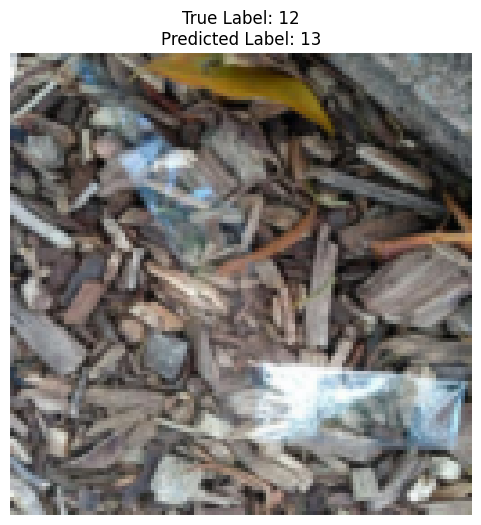

Gambar yang ditampilkan adalah contoh dari kelas: 12
Model memprediksi gambar ini sebagai kelas: 13


In [15]:
# Langkah 6: Tampilkan Salah Satu Output (Contoh Hasil Prediksi)

import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

# Pastikan model dalam mode evaluasi
model_for_testing.eval()

# Ambil satu gambar acak dari dataset testing
random_idx = random.randint(0, len(test_dataset_cnn) - 1)
random_image, true_label_idx = test_dataset_cnn[random_idx]

# Dapatkan nama kelas sebenarnya
true_class_name = test_dataset_cnn.classes[true_label_idx]

# Lakukan prediksi pada gambar
# Tambahkan dimensi batch (unsqueeze(0)) karena model mengharapkan input batch
input_image = random_image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model_for_testing(input_image)
    # Dapatkan indeks kelas prediksi dengan skor tertinggi
    _, predicted_label_idx = torch.max(output.data, 1)

# Dapatkan nama kelas prediksi
predicted_class_name = test_dataset_cnn.classes[predicted_label_idx.item()]

# Tampilkan gambar dan hasil prediksi
# Untuk menampilkan gambar, kita perlu mengubah tensor kembali ke format gambar
# dan melakukan denormalisasi jika sebelumnya dinormalisasi
# (ini adalah denormalisasi sederhana, mungkin perlu disesuaikan dengan mean/std yang digunakan)
img_display = random_image.cpu().numpy().transpose((1, 2, 0)) # C, H, W to H, W, C
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1) # Klip nilai ke rentang [0, 1]

plt.figure(figsize=(6, 6))
plt.imshow(img_display)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print(f"Gambar yang ditampilkan adalah contoh dari kelas: {true_class_name}")
print(f"Model memprediksi gambar ini sebagai kelas: {predicted_class_name}")

In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive jika belum ter-mount
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Tentukan folder hasil yang ingin disimpan
yolo_results_dir = 'runs/detect/yolov8n_taco_detection' # Folder hasil training YOLOv8
cnn_dataset_dir = '/content/taco-dataset_cnn' # Folder dataset CNN yang dikonversi

# Tentukan folder tujuan di Google Drive
# Ganti path ini jika Anda ingin menyimpan di lokasi lain di Drive Anda
drive_destination_path = '/content/drive/My Drive/Hasil_Training_TACO'

# Buat folder tujuan di Drive jika belum ada
os.makedirs(drive_destination_path, exist_ok=True)

print(f"Menyalin folder hasil '{yolo_results_dir}' ke '{drive_destination_path}'...")
try:
    # Hapus folder tujuan di Drive jika sudah ada untuk menghindari error saat menyalin
    if os.path.exists(os.path.join(drive_destination_path, os.path.basename(yolo_results_dir))):
        shutil.rmtree(os.path.join(drive_destination_path, os.path.basename(yolo_results_dir)))
    shutil.copytree(yolo_results_dir, os.path.join(drive_destination_path, os.path.basename(yolo_results_dir)))
    print("Penyalinan folder hasil YOLOv8 selesai.")
except Exception as e:
    print(f"Gagal menyalin folder hasil YOLOv8: {e}")

print(f"Menyalin folder dataset CNN '{cnn_dataset_dir}' ke '{drive_destination_path}'...")
try:
    # Hapus folder tujuan di Drive jika sudah ada untuk menghindari error saat menyalin
    if os.path.exists(os.path.join(drive_destination_path, os.path.basename(cnn_dataset_dir))):
        shutil.rmtree(os.path.join(drive_destination_path, os.path.basename(cnn_dataset_dir)))
    shutil.copytree(cnn_dataset_dir, os.path.join(drive_destination_path, os.path.basename(cnn_dataset_dir)))
    print("Penyalinan folder dataset CNN selesai.")
except Exception as e:
    print(f"Gagal menyalin folder dataset CNN: {e}")

print("\nProses penyimpanan ke Google Drive selesai.")

Menyalin folder hasil 'runs/detect/yolov8n_taco_detection' ke '/content/drive/My Drive/Hasil_Training_TACO'...
Penyalinan folder hasil YOLOv8 selesai.
Menyalin folder dataset CNN '/content/taco-dataset_cnn' ke '/content/drive/My Drive/Hasil_Training_TACO'...
Penyalinan folder dataset CNN selesai.

Proses penyimpanan ke Google Drive selesai.


In [19]:
# Tampilkan Hasil Akurasi Training dan Validasi dari K-Fold CNN

print("Hasil Akurasi Training dan Validasi per Fold (dari K-Fold Cross-Validation):")

if 'fold_results' in locals():
    for fold, results in fold_results.items():
        history = results['history']
        # Ambil akurasi tertinggi yang dicapai pada validasi di fold ini
        best_val_acc = max(history['val_acc']) if history['val_acc'] else 0.0
        # Ambil akurasi pada epoch terakhir training di fold ini
        last_train_acc = history['train_acc'][-1] if history['train_acc'] else 0.0
        last_val_acc = history['val_acc'][-1] if history['val_acc'] else 0.0


        print(f"\n{fold}:")
        print(f"  Akurasi Training (epoch terakhir): {last_train_acc:.4f}")
        print(f"  Akurasi Validasi (terbaik): {best_val_acc:.4f}")
        print(f"  Akurasi Validasi (epoch terakhir): {last_val_acc:.4f}")

else:
    print("Variabel 'fold_results' tidak ditemukan. Mohon jalankan kembali tahap training K-Fold.")

print("\nCatatan: Akurasi ini adalah performa model pada data yang digunakan selama training/validasi K-Fold, bukan pada test set yang independen.")

Hasil Akurasi Training dan Validasi per Fold (dari K-Fold Cross-Validation):

Fold 1:
  Akurasi Training (epoch terakhir): 0.9424
  Akurasi Validasi (terbaik): 0.3709
  Akurasi Validasi (epoch terakhir): 0.3701

Fold 2:
  Akurasi Training (epoch terakhir): 0.7810
  Akurasi Validasi (terbaik): 0.3677
  Akurasi Validasi (epoch terakhir): 0.3677

Catatan: Akurasi ini adalah performa model pada data yang digunakan selama training/validasi K-Fold, bukan pada test set yang independen.
